# Introduction

### Note

If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

---

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

---

# Color

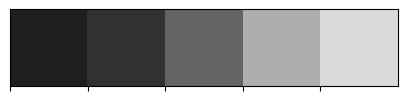

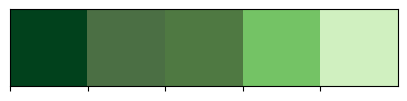

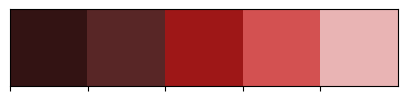

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm # Make sure to import tqdm

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150

# Correct folder path for training data
training_folder_path = '/content/drive/MyDrive/Tubes DL/Training'
testing_folder_path = '/content/drive/MyDrive/Tubes DL/Testing'

# Loop through each label and its corresponding folder within the training directory
for label in labels:
    label_folder_path = os.path.join(training_folder_path, label)  # Create path to label folder
    for filename in tqdm(os.listdir(label_folder_path)):  # Iterate over files in label folder
        # Construct the full image path
        img_path = os.path.join(label_folder_path, filename)
        # Read and process the image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)
        else:
            print(f"Could not read image: {img_path}")

# Loop through each label and its corresponding folder within the testing directory
for label in labels:
    label_folder_path = os.path.join(testing_folder_path, label)  # Create path to label folder
    for filename in tqdm(os.listdir(label_folder_path)):  # Iterate over files in label folder
        # Construct the full image path
        img_path = os.path.join(label_folder_path, filename)
        # Read and process the image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)
        else:
            print(f"Could not read image: {img_path}")


X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:29<00:00,  2.55it/s]


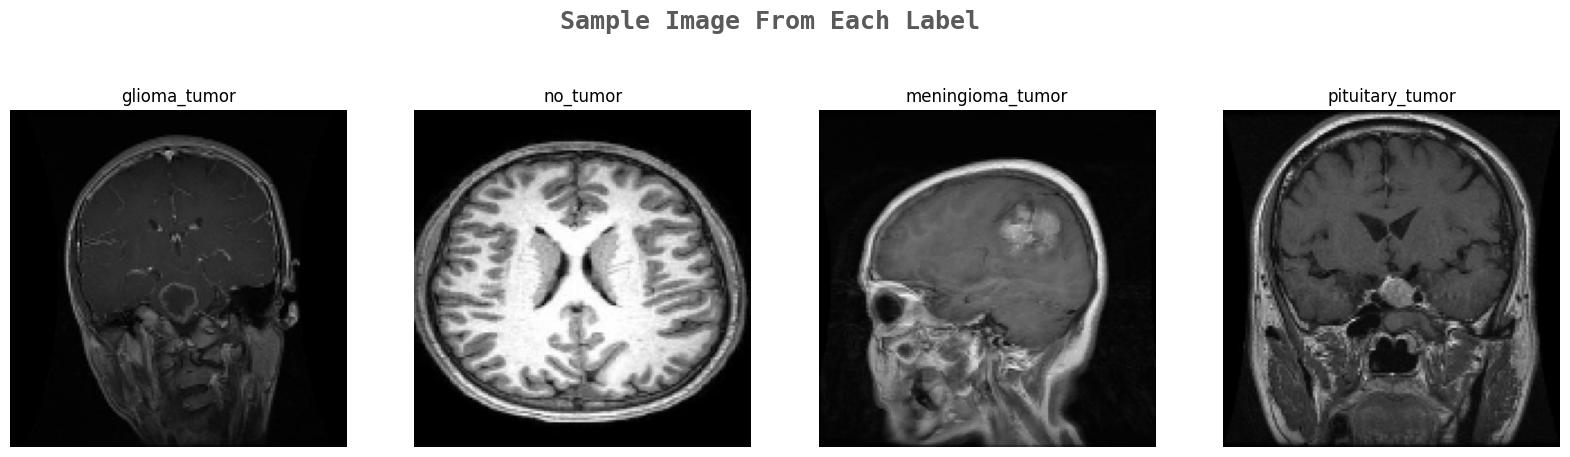

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3307, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [ ]:
# model = effnet.output
# model = tf.keras.layers.GlobalAveragePooling2D()(model)
# model = tf.keras.layers.Dropout(rate=0.5)(model)
# model = tf.keras.layers.Dense(4,activation='softmax')(model)
# model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


---

### **1. `effnet.output`**
- Mengambil **output dari backbone EfficientNet**.
- Output ini berupa feature map yang dihasilkan oleh arsitektur pre-trained **EfficientNet**.
- **EfficientNet** digunakan sebagai **feature extractor** untuk mengurangi kebutuhan melatih model dari nol.

---

### **2. `GlobalAveragePooling2D()`**
- **Fungsi**: Mengubah feature map dua dimensi (2D) menjadi vektor satu dimensi (1D) dengan menghitung rata-rata nilai pada setiap channel.
- **Alasan penggunaan**:
  - Mengurangi dimensi spasial tanpa kehilangan informasi penting.
  - Membantu mencegah overfitting dengan menyederhanakan representasi data.
- **Efek pada model**:
  - Menghasilkan vektor fitur dari gambar input yang siap digunakan untuk klasifikasi lebih lanjut.

---

### **3. `Dense(256, activation='relu')`**
- **Fungsi**: Menambahkan layer fully connected dengan 256 neuron.
- **Aktivasi `relu`**:
  - **Rectified Linear Unit (ReLU)** adalah fungsi aktivasi yang umum digunakan pada hidden layer.
  - Memberikan sparsity dan membantu jaringan belajar pola non-linear.
- **Alasan penggunaan**:
  - Layer ini bertindak sebagai "penyaring informasi", mempelajari representasi fitur yang lebih kompleks sebelum klasifikasi.

---

### **4. `BatchNormalization()`**
- **Fungsi**: Menormalkan output layer sebelumnya.
- **Manfaat**:
  - Membantu stabilitas proses pelatihan.
  - Mempercepat konvergensi model dengan menjaga distribusi data di setiap layer tetap stabil.
  - Mengurangi ketergantungan terhadap inisialisasi parameter awal.
- **Efek pada model**:
  - Model menjadi lebih tahan terhadap perubahan dalam distribusi data selama pelatihan.

---

### **5. `Dropout(rate=0.4)`**
- **Fungsi**: Menonaktifkan (drop) 40% neuron secara acak selama pelatihan.
- **Alasan penggunaan**:
  - Mencegah overfitting dengan mengurangi ketergantungan model pada neuron tertentu.
  - Membuat model lebih generalisasi pada data baru.
- **Perubahan dari kode sebelumnya**:
  - Dropout rate dikurangi dari 0.5 ke 0.4 untuk menjaga lebih banyak informasi tetap dipertahankan.

---

### **6. `Dense(4, activation='softmax')`**
- **Fungsi**: Output layer dengan 4 neuron, masing-masing merepresentasikan probabilitas untuk setiap kelas.
- **Aktivasi `softmax`**:
  - Mengubah output menjadi distribusi probabilitas (jumlahnya menjadi 1).
  - Digunakan untuk klasifikasi multi-kelas.
- **Alasan penggunaan**:
  - Model diharapkan memprediksi satu dari empat kelas (klasifikasi multi-kelas).

---

### **7. `Model(inputs=effnet.input, outputs=model)`**
- **Fungsi**: Membuat model baru dengan:
  - **Input**: Sama seperti input EfficientNet (gambar dengan dimensi tertentu).
  - **Output**: Layer tambahan yang telah dimodifikasi untuk tugas klasifikasi spesifik.
- **Efek pada model**:
  - Backbone EfficientNet digunakan untuk ekstraksi fitur, sementara layer tambahan digunakan untuk klasifikasi.

---

### **Keuntungan dari Modifikasi Ini**
1. **Efisiensi dan Fleksibilitas**:
   - Memanfaatkan EfficientNet untuk ekstraksi fitur yang kuat dan efisien.
   - Layer tambahan dirancang fleksibel untuk menyelesaikan tugas spesifik.

2. **Pencegahan Overfitting**:
   - Kombinasi **Dropout** dan **BatchNormalization** mengurangi kemungkinan overfitting, terutama pada dataset kecil.

3. **Kemampuan Belajar Fitur Kompleks**:
   - Fully connected layer dengan 256 neuron memberikan kapasitas yang cukup untuk mempelajari pola data.

4. **Kompatibilitas Multi-Kelas**:
   - Output layer dengan softmax ideal untuk klasifikasi dengan 4 kelas.

---

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(256, activation='relu')(model)  # Layer tambahan
model = tf.keras.layers.BatchNormalization()(model)          # Batch Normalization
model = tf.keras.layers.Dropout(rate=0.4)(model)             # Dropout yang lebih kecil
model = tf.keras.layers.Dense(4, activation='softmax')(model)  # Output layer
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 4,337,024 (16.54 MB)

 Non-trainable params: 42,535 (166.16 KB)

We finally compile our model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
tensorboard = TensorBoard(log_dir = 'logs')
# Changing the file extension from 'h5' to 'keras' to match the expected format
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

epoch awalnya 12


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7046 - loss: 0.9579
Epoch 1: val_accuracy improved from -inf to 0.61074, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 143s 759ms/step - accuracy: 0.7057 - loss: 0.9544 - val_accuracy: 0.6107 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 2/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8975 - loss: 0.2998
Epoch 2: val_accuracy improved from 0.61074 to 0.85906, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.8977 - loss: 0.2994 - val_accuracy: 0.8591 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 3/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9430 - loss: 0.1548
Epoch 3: val_accuracy improved from 0.85906 to 0.91275, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9432 - loss: 0.1545 - val_accuracy: 0.9128 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 4/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.97

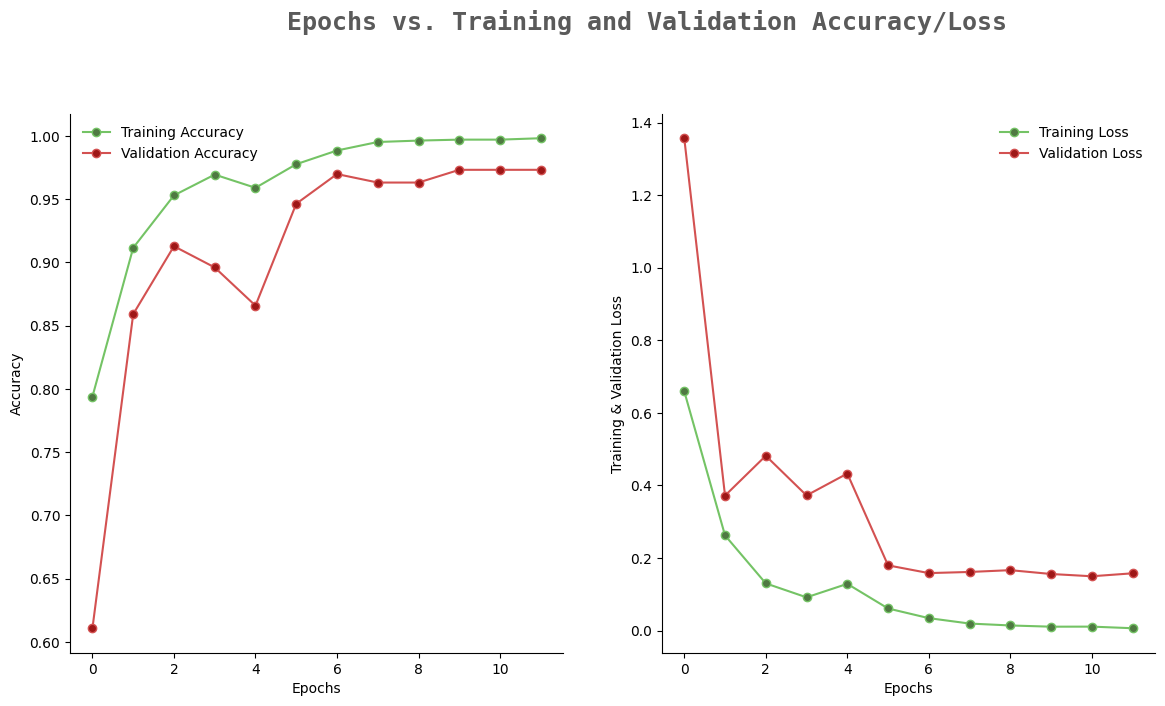

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        96
           1       0.98      0.98      0.98        48
           2       0.97      0.99      0.98        89
           3       1.00      1.00      1.00        98

    accuracy                           0.98       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.99      0.98      0.98       331



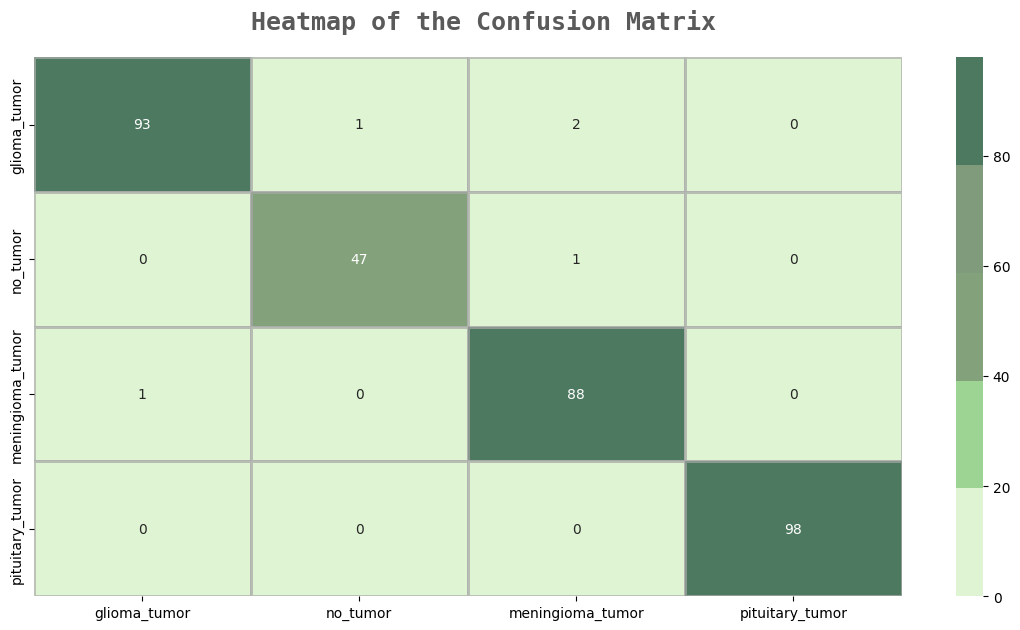

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
The Model predicts that it is a Meningioma Tumor


In [ ]:
#model.save('model_klasifikasi_tumor.h5')  # Menyimpan model dalam format HDF5

---

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.<br>
I also made widgets which can make predictions on an image from your local machine!

---

# <center>Thank You!